# Evaluating impacts and mitigation strategies of missing abstracts

In this analysis we aim to understand the impact of missing abstracts and our mitigation attempts by adding missing abstracts.
We do so by picking a random sample of 1M works and trying to retrieve abstracts for those

In [40]:
import gzip
import logging
from pathlib import Path


import httpx
import numpy as np
import pandas as pd
import orjson as json
from tqdm import tqdm
from matplotlib import pyplot as plt

logging.basicConfig(format='%(asctime)s [%(levelname)s] %(name)s (%(process)d): %(message)s', level=logging.INFO)
logging.getLogger('httpx').setLevel(logging.WARNING)
logger = logging.getLogger('analysis')
logger.setLevel(logging.DEBUG)

## Setup

In [17]:
fp_snapshot = Path('/mnt/bulk/openalex/openalex-snapshot')
fp_target = Path('/mnt/bulk/openalex/oa_ids.txt')
fp_sample = Path('/mnt/bulk/openalex/oa_ids_sample.txt')
fp_infos = Path('/mnt/bulk/openalex/oa_sample.csv')
oa_base = 'http://localhost:8984/solr/openalex'

## 1) Prepare list of OpenAlex IDs

In [ ]:
if fp_target.exists():
    raise Error('File already exists, delete first if you really want to rebuild the ID list for 8h')

partitions = list(sorted(fp_snapshot.glob(f'data/works/**/*.gz')))
logger.info(f'Looks like there are {len(partitions):,} partitions.')

progress = tqdm.tqdm(total=len(partitions))

n_total = 0
n_failed = 0
with open(fp_target, 'w') as f_out:
    for pi, partition in enumerate(partitions, 1):
        progress.set_postfix_str(
            f'total={n_total:,}, '
            f'failed={n_failed:,}, '
            f'filesize={partition.stat().st_size / 1024 / 1024 / 1024:,.2f}GB, '
            f'partition={"/".join(partition.parts[-2:])}',
        )

        with gzip.open(partition, 'rb') as f_in:
            progress.set_description_str(f'READ ({pi:,})')
            ids = [json.loads(line).get('id','')[len('https://openalex.org/'):] for line in f_in]
            f_out.write('\n'.join(ids) + '\n')
        progress.update()

## 2) Select random sample

```
% cat oa_ids.txt | wc -l
463042077

% ll oa_ids.txt
239217975 5,2G -rw-rw-r-- 1 rept rept 5,2G Dez 17 01:48 oa_ids.txt
```

In [ ]:
%%bash
shuf -n 1000000 oa_ids.txt > oa_ids_sample.txt

## 3) Load extra info for samples

In [22]:
def batched(iterable, bs: int):
    queue = []
    for it in iterable:
        queue.append(it)
        if len(queue) > bs:
            yield queue
            queue = []
    yield queue

if not fp_infos.exists():
    _bs=500
    infos = []
    with open(fp_sample) as f_in:
        for batch in tqdm(batched(f_in, _bs), total=1000000/_bs):
            res = httpx.get(
                f'{oa_base}/select',
                params={
                    'df': 'id',
                    'fl': 'id,doi,publication_year,created_date,is_xpac,is_retracted,is_open_access,publisher,source,abstract_source',
                    'q.op': 'OR',
                    'q': ' '.join(batch)
                },
                timeout=120,
            )
            infos += res.json().get('response', {}).get('docs', [])
    pd.DataFrame(infos).to_csv(fp_infos, index=False)

df = pd.read_csv(fp_infos)

100%|█████████▉| 1997/2000.0 [16:11<00:01,  2.06it/s]


In [47]:
df['publication_year'] = df['publication_year'].astype('Int16')

In [48]:
print(df.shape)
df.head()

(19964, 10)


,is_retracted,is_xpac,publication_year,is_open_access,abstract_source,publisher,id,created_date,source,doi
0,False,False,2013,False,OpenAlex,Henan University,W2384430180,2016-06-24T00:00:00Z,Journal of Henan University,NaN
1,False,False,2009,False,OpenAlex,NaN,W2266632663,2016-06-24T00:00:00Z,한국식생활문화학회지,NaN
2,False,False,2008,False,OpenAlex,NaN,W1257733155,2025-10-10T00:00:00Z,福建建筑,NaN
3,False,False,2015,False,OpenAlex,NaN,W1751672755,2025-10-10T00:00:00Z,Вестник Ленинградского государственного универ...,NaN
4,False,False,2011,False,NaN,Jesuit Publications,W2592384868,2025-10-10T00:00:00Z,Eureka street,NaN


## Overview

In [99]:
urls = {
    'Total': 'https://api.openalex.org/works?group_by=publication_year&per_page=200&include_xpac=false&filter=publication_year:1900-2025',
    'Has abstract': 'https://api.openalex.org/works?group_by=publication_year&per_page=200&include_xpac=false&filter=publication_year:1990-2025,has_abstract:true',
    'Total (xpac)': 'https://api.openalex.org/works?group_by=publication_year&per_page=200&include_xpac=true&filter=publication_year:1900-2025',
    'Has abstract (xpac)': 'https://api.openalex.org/works?group_by=publication_year&per_page=200&include_xpac=true&filter=publication_year:1990-2025,has_abstract:true',
}
df_total = pd.concat([
     pd.DataFrame([{'PY': int(grp['key']), key: int(grp['count'])} for grp in httpx.get(url).json().get('group_by')]).set_index('PY')
    for key, url in urls.items()
], axis=1).fillna(0).astype(int)
print(df_total.shape)
df_total.head()

(126, 4)


,Total,Has abstract,Total (xpac),Has abstract (xpac)
PY,,,,
2025,12105787,6422106,43093193,29221575
2020,11087613,7775536,16328837,10649896
2019,10353902,7096585,16606949,10765429
2023,10189750,8013834,21689679,12136612
2016,10167746,6278609,16902435,10206578


In [24]:
n_total = df.shape[0]
print(f'Total: {n_total:,}')
for field in ['is_xpac', 'is_retracted', 'is_open_access']:
    n = df[field].sum()
    print(    f'{field} == true: {n:,} ({n/n_total:.2%}; Ñ={n_total-n:,})')
for field in ['abstract_source', 'publication_year', 'doi', 'created_date', 'publisher', 'source']:
    n = df[field].notna().sum()
    print(f'{field} is not None: {n:,} ({n/n_total:.2%}; Ñ={n_total-n:,})')

Total: 19,964
is_xpac == true: 1,256 (6.29%; Ñ=18,708)
is_retracted == true: 1 (0.01%; Ñ=19,963)
is_open_access == true: 1,802 (9.03%; Ñ=18,162)
abstract_source is not None: 9,341 (46.79%; Ñ=10,623)
publication_year is not None: 19,763 (98.99%; Ñ=201)
doi is not None: 1,976 (9.90%; Ñ=17,988)
created_date is not None: 19,964 (100.00%; Ñ=0)
publisher is not None: 7,084 (35.48%; Ñ=12,880)
source is not None: 19,057 (95.46%; Ñ=907)


,Total (sample),Has abstract (sample),ratio,Total,Has abstract,Total (xpac),Has abstract (xpac)
PY,,,,,,,
1990,164,119,72.560976,2004421,1047564,2458367,1175948
1991,138,86,62.318841,2006341,1092894,2431643,1229609
1992,158,108,68.354430,2091705,1146696,2566435,1304737
1993,158,111,70.253165,2187842,1199952,2657960,1362525
1994,201,131,65.174129,2305746,1277867,2801782,1429531
1995,228,157,68.859649,2445509,1349735,2996204,1515999
1996,226,144,63.716814,2649775,1420971,3217103,1606681
1997,251,184,73.306773,2746315,1467506,3284174,1634893
1998,292,205,70.205479,2926777,1557832,3497623,1741283


<Axes: xlabel='PY'>

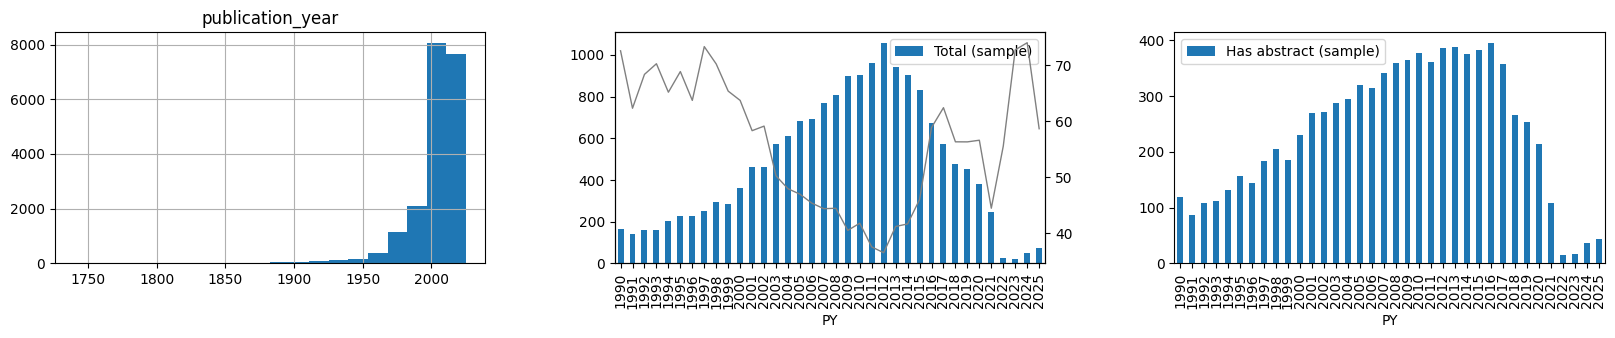

In [101]:
fig, axes = plt.subplots(1, 3, figsize=(20, 3))

df.hist('publication_year', ax=axes[0], bins=20)

cnt_total, _ = np.histogram(df[df['publication_year'].notna()]['publication_year'], range=(1990, 2026), bins=36)
cnt_abs, years = np.histogram(df[df['publication_year'].notna() & df['abstract_source'].isna()]['publication_year'], range=(1990, 2026), bins=36)

df_hist = pd.DataFrame({
    'PY': years[:-1].astype(int),
    'Total (sample)': cnt_total,
    'Has abstract (sample)': cnt_abs,
    'ratio': cnt_abs / cnt_total * 100,
}).set_index('PY').join(df_total)
display(df_hist)

df_hist.plot.bar(y='Total (sample)', ax=axes[1])
sec = axes[1].twinx()
sec.plot(np.arange(36), df_hist['ratio'], lw=1, c='grey')
df_hist.plot.bar(y='Has abstract (sample)', ax=axes[2])
#df_hist.plot.line(y='ratio', ax=sec)

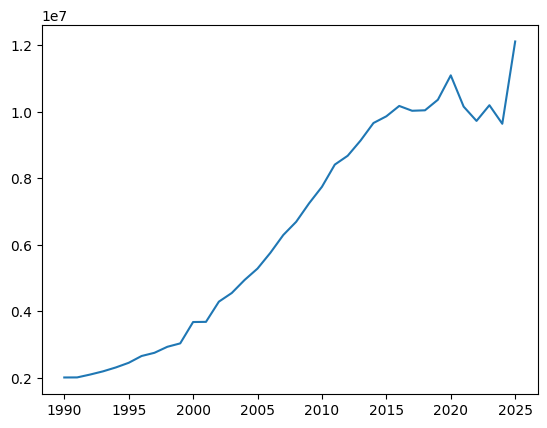

In [108]:
plt.plot(df_hist['Total'])

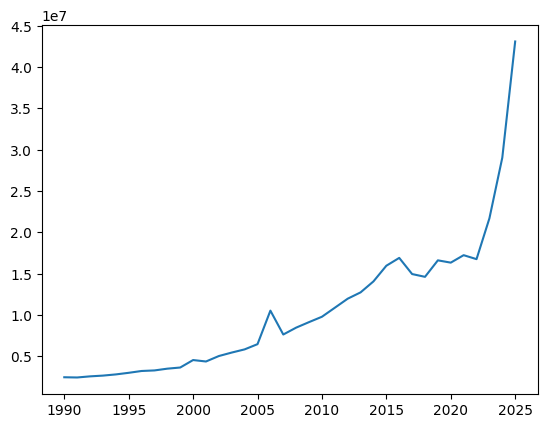

In [105]:
plt.plot(df_hist['Total (xpac)'])

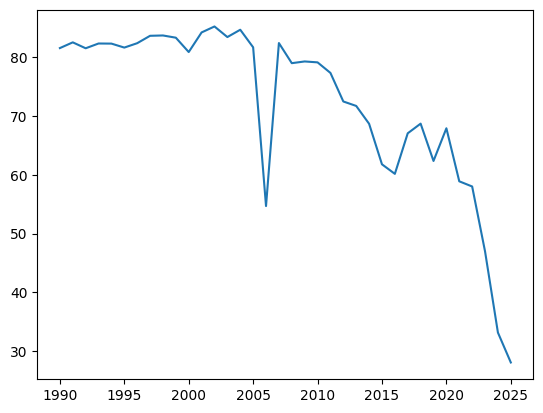

In [107]:
plt.plot(df_hist['Total'] / df_hist['Total (xpac)'] * 100)

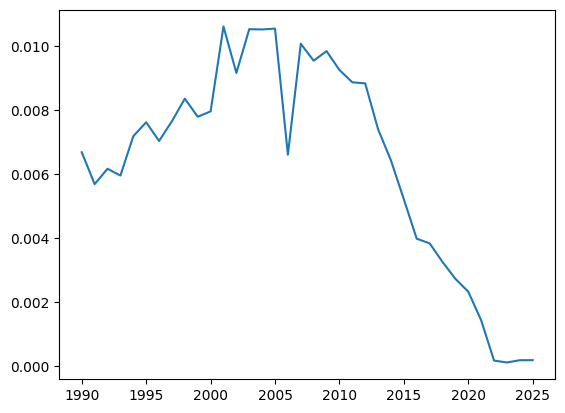

In [106]:
plt.plot(df_hist['Total (sample)'] / df_hist['Total (xpac)'] * 100)